In [1]:
# %matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from census import Census
import requests

# Access cleaned housing data (using Power Query in Excel)

metro_hv_df = pd.read_csv("Data/Metro_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month_modified.csv")
metro_inventory_df = pd.read_csv("Data/Metro_invt_fs_uc_sfr_sm_month_modified.csv")
zipcode_hv_df = pd.read_csv("Data/Zip_zhvi_uc_sfr_tier_0.33_0.67_sm_sa_month_modified.csv")
census_df = pd.read_csv("Data/Census/all_census_data_zipcode.csv")

# Merge house value file with census file
hv_census_df = pd.merge(zipcode_hv_df, census_df, how='outer', on='Zipcode_Year')

# Drop zipcodes that don't have exist in one of the files
hv_census_df = hv_census_df.dropna()

# Adding affordability column (how many years of household income would it take to buy a house at the average house price)
hv_census_df["Affordability"] = hv_census_df["Average House Price"] / hv_census_df["Household Income"]

hv_census_df = hv_census_df.drop(columns=['Zipcode_y', 'Year_y'])
hv_census_df = hv_census_df.rename(columns={"Zipcode_x": "Zipcode", "Year_x": "Year"})
hv_census_df["Zipcode"] = hv_census_df["Zipcode"].astype(int)
hv_census_df["Year"] = hv_census_df["Year"].astype(int)
hv_census_df["Population"] = hv_census_df["Population"].astype(int)
hv_census_df["Household Income"] = hv_census_df["Household Income"].astype(int)
hv_census_df["Per Capita Income"] = hv_census_df["Per Capita Income"].astype(int)
hv_census_df["Poverty Count"] = hv_census_df["Poverty Count"].astype(int)
hv_census_df["Average House Price"] = hv_census_df["Average House Price"].round(2)

In [2]:
# The difference in affordability is increasing over the years between areas with lower household income to areas with higher household income.

hv_census_df_2013 = hv_census_df.loc[hv_census_df["Year"] == 2013]

hv_census_df_2013["Household Income"].describe()

count       173.000000
mean      57734.635838
std       18688.906655
min       19000.000000
25%       44141.000000
50%       54572.000000
75%       68108.000000
max      139543.000000
Name: Household Income, dtype: float64

<AxesSubplot:>

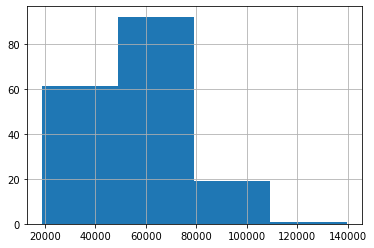

In [3]:
hv_census_df_2013["Household Income"].hist(bins=4)

In [4]:
hv_census_df_2013["Household Income"].median()

54572.0

In [5]:
hv_census_df_2013["Income Category"] = np.where(hv_census_df_2013["Household Income"] > hv_census_df_2013["Household Income"].median(), "Higher", "Lower")
        
hv_census_df_2013

<ipython-input-5-a40e55b8efbf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hv_census_df_2013["Income Category"] = np.where(hv_census_df_2013["Household Income"] > hv_census_df_2013["Household Income"].median(), "Higher", "Lower")


,Zipcode,Year,Average House Price,Zipcode_Year,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Affordability,Income Category
0,30349,2013,80892.08,30349_2013,68941,31.8,43498,21145,12508,1.859674,Lower
9,30044,2013,121165.00,30044_2013,81764,33.2,51827,22190,13520,2.337874,Lower
18,30043,2013,165054.17,30043_2013,83855,33.9,67260,26317,6861,2.453972,Higher
27,30096,2013,155881.25,30096_2013,67110,32.2,49883,25227,10866,3.124937,Lower
36,30024,2013,268330.42,30024_2013,68650,36.2,99931,37352,4395,2.685157,Higher
...,...,...,...,...,...,...,...,...,...,...,...
1746,30641,2013,160104.83,30641_2013,2069,37.1,82206,31994,48,1.947605,Higher
1764,30137,2013,99726.33,30137_2013,1838,42.5,61667,24923,169,1.617175,Higher
1773,30148,2013,136524.92,30148_2013,413,48.4,40227,24203,71,3.393863,Lower
1807,30177,2013,96778.25,30177_2013,1369,35.9,33866,15101,143,2.857682,Lower


In [6]:
hv_census_groupby_year_df = hv_census_df.groupby(by = ["Year"])["Average House Price", "Household Income"].mean()

hv_census_groupby_year_df = hv_census_groupby_year_df.reset_index()

hv_census_groupby_year_df

<ipython-input-6-00261e8fee45>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hv_census_groupby_year_df = hv_census_df.groupby(by = ["Year"])["Average House Price", "Household Income"].mean()


,Year,Average House Price,Household Income
0,2013,180091.518035,57734.635838
1,2014,200458.171445,57883.630058
2,2015,213458.629593,58436.872093
3,2016,227128.015665,60056.138728
4,2017,243091.878837,62751.476744
5,2018,264147.298198,66667.656977
6,2019,278648.658953,69802.622093


In [7]:
Price_2013 = hv_census_groupby_year_df["Average House Price"][0]

Household_Income_2013 = hv_census_groupby_year_df["Household Income"][0]

hv_census_groupby_year_df["House Price Index"] = hv_census_groupby_year_df["Average House Price"]/Price_2013

hv_census_groupby_year_df["Household Income Index"] = hv_census_groupby_year_df["Household Income"]/Household_Income_2013

hv_census_groupby_year_df

,Year,Average House Price,Household Income,House Price Index,Household Income Index
0,2013,180091.518035,57734.635838,1.000000,1.000000
1,2014,200458.171445,57883.630058,1.113091,1.002581
2,2015,213458.629593,58436.872093,1.185279,1.012163
3,2016,227128.015665,60056.138728,1.261181,1.040210
4,2017,243091.878837,62751.476744,1.349824,1.086895
5,2018,264147.298198,66667.656977,1.466739,1.154726
6,2019,278648.658953,69802.622093,1.547261,1.209025


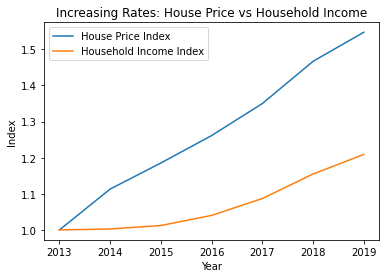

In [8]:
hv_census_groupby_year_df.plot.line( x="Year", y = {"House Price Index", "Household Income Index"}, title = "Increasing Rates: House Price vs Household Income")

plt.ylabel("Index")

plt.savefig("House Price vs Income.jpg")

In [9]:
hv_census_df_2013 = hv_census_df_2013.iloc[:, [0, 10]]

hv_census_df_2013

,Zipcode,Income Category
0,30349,Lower
9,30044,Lower
18,30043,Higher
27,30096,Lower
36,30024,Higher
...,...,...
1746,30641,Higher
1764,30137,Higher
1773,30148,Lower
1807,30177,Lower


In [10]:
hv_census_df_income_category = hv_census_df.merge(hv_census_df_2013, how="outer", on="Zipcode")

hv_census_df_income_category

,Zipcode,Year,Average House Price,Zipcode_Year,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Affordability,Income Category
0,30349,2013,80892.08,30349_2013,68941,31.8,43498,21145,12508,1.859674,Lower
1,30349,2014,98395.42,30349_2014,70414,31.9,43379,21164,14694,2.268273,Lower
2,30349,2015,106951.42,30349_2015,70334,32.9,44987,21254,13927,2.377385,Lower
3,30349,2016,116409.83,30349_2016,69996,33.0,45573,22093,12907,2.554360,Lower
4,30349,2017,129494.58,30349_2017,73310,32.6,46998,23245,12650,2.755321,Lower
...,...,...,...,...,...,...,...,...,...,...,...
1202,30289,2015,210094.42,30289_2015,63,63.5,25625,16537,5,8.198807,Higher
1203,30289,2016,212571.17,30289_2016,59,63.6,25000,16507,5,8.502847,Higher
1204,30289,2017,227717.25,30289_2017,38,67.0,22250,21897,4,10.234483,Higher
1205,30289,2018,248117.67,30289_2018,276,35.2,153452,36223,10,1.616907,Higher


In [11]:
hv_census_df_income_category = hv_census_df_income_category.loc[:, {"Zipcode", "Year", "Affordability", "Income Category"}]

# hv_census_df_income_category = hv_census_df_income_category.pivot(columns = "Income Category", values = ["Year", "Zipcode", "Affordability"])

# hv_census_df_income_category

hv_census_df_income_category_grouped = hv_census_df_income_category.groupby(by = ["Year", "Income Category"])["Affordability"].mean()

hv_census_df_income_category_grouped = hv_census_df_income_category_grouped.reset_index()

hv_census_df_income_category_grouped = hv_census_df_income_category_grouped.pivot(index = "Year", columns = "Income Category", values = "Affordability")

hv_census_df_income_category_grouped = hv_census_df_income_category_grouped.reset_index()

hv_census_df_income_category_grouped

Income Category,Year,Higher,Lower
0,2013,3.210802,2.810504
1,2014,3.563644,3.180452
2,2015,3.737760,3.356030
3,2016,3.863248,3.544969
4,2017,3.939088,3.673378
5,2018,3.925825,3.909932
6,2019,3.937119,3.997202


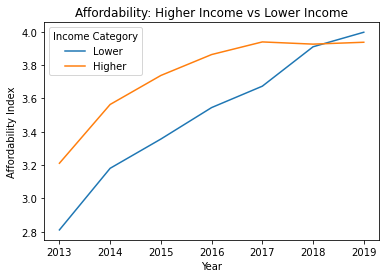

In [12]:
hv_census_df_income_category_grouped.plot.line( x="Year", y = {"Higher", "Lower"}, title = "Affordability: Higher Income vs Lower Income")

plt.ylabel("Affordability Index")

plt.savefig("High vs Low Income.jpg")

In [16]:
# ANOVA Test to see whether the differences are meaningful

# import scipy.stats as stats

hv_census_df_income_category_grouped.index.rename("Index")

hv_census_df_income_category_grouped_Lower = hv_census_df_income_category_grouped.pivot(index = "Index", columns = "Year", values = "Lower")

# hv_census_df_income_category_grouped_Higher = hv_census_df_income_category_grouped.pivot(index = "Income Category", columns = "Year", values = "Higher")

hv_census_df_income_category_grouped_Lower

# for x in range(2013, 2019):

#     next_year = x+1
    
#     fvalue, pvalue = stats.f_oneway(hv_census_pivot_df[x], hv_census_pivot_df[next_year])
    
#     pvalue = pvalue.round(2)
    
#     if pvalue < 0.05:
#         print(f'There is significant difference in house affordability between {x} and {next_year} (p = {pvalue}).')
#     else: print(f'There is no significant difference in house affordability between {x} and {next_year} (p = {pvalue}).')
        
# fvalue, pvalue = stats.f_oneway(hv_census_pivot_df[2013], hv_census_pivot_df[2019])

# if pvalue < 0.5:
#     print(f'There is significant difference in house affordability between 2013 and 2019 (p = {pvalue}).')
# else: print(f'There is no significant difference in house affordability between 2013 and 2019 (p = {pvalue}).')

KeyError: 'Index'